# **New Jersey Institute of Technology**
# CS 675: Machine Learning, Spring 2022
 
*   Instructor: Dr. Przemyslaw Musialski
*   TA: Haotian Yin
 
# Assignment 4
* Date: 3/27/2022
* **Due: 4/7/2022, 11:59pm EST**
* Total possible points: 30. 
 
 
## Instructions
*   Copy it locally or edit it as a copy in your Google-Colab (File-->Save a Copy in Drive). 
*   Look for notebook cells starting with **"Task #"**. **Edit only in the indicated areas!** Do not forget to write brief documentation for each task in the dedicated cell areas. **Do not edit in other areas!**
*   Delivery Method: Upload a Jupyter notebook following the suggested name convention. 
*   Note: you can access the file only with your NJIT-Google-Account.  **Private accounts will not have access**. 
*   Submit your solution on CANVAS. Late submissions are penalized with 10% of total points per day. 
 
 
## Academic Policy
A set of ethical principles governing this course:
*   It is okay to share information and knowledge with your 
colleagues, but
*   **It is not okay** to share the code,
*   **It is not okay** to post or give out your code to others (also in the future!),
*   **It is not okay** to use code from others (also from the past) for this Assignment!
 
**Any noticed disregard of these principles will be sanctioned** as per the Academic Integrity Policy of NJIT (http://www5.njit.edu/policies/sites/policies/files/academic-integrity-code.pdf).
 
 
## Late Policy
Late submissions are penalized with 10% of total points per day.

## Remarks
I recommend to study the tutorials from the book "Python Data Science Handbook" on Colab: 
https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/Index.ipynb

In particular for this assigment we will use 

SVM: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb



In [9]:
#@title Imports and Helper and Visualization Functions

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    """Plot the decision boundary of DecisionTree"""
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    # plt.axis('equal')
    # ax.axis('off')    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    # ax.set(xlim=xlim, ylim=ylim)

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

---
## Data Loading and Preprocessing

We are using the Seaborn libary for data loading and preprocessing: https://seaborn.pydata.org/introduction.html

For this assigment we use the well known 'Iris Flower'-Dataset, which is well known in the ML community as a testing set (https://en.wikipedia.org/wiki/Iris_flower_data_set)



In [2]:
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# for this excersise we remove the  'setosa' species
iris = iris.loc[iris['species'] != 'setosa']

The next command `pairplot`. By default, this function will create a grid of Axes such that each numeric variable in data will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot is drawn to show the marginal distribution of the data in each column. See: https://seaborn.pydata.org/generated/seaborn.pairplot.html

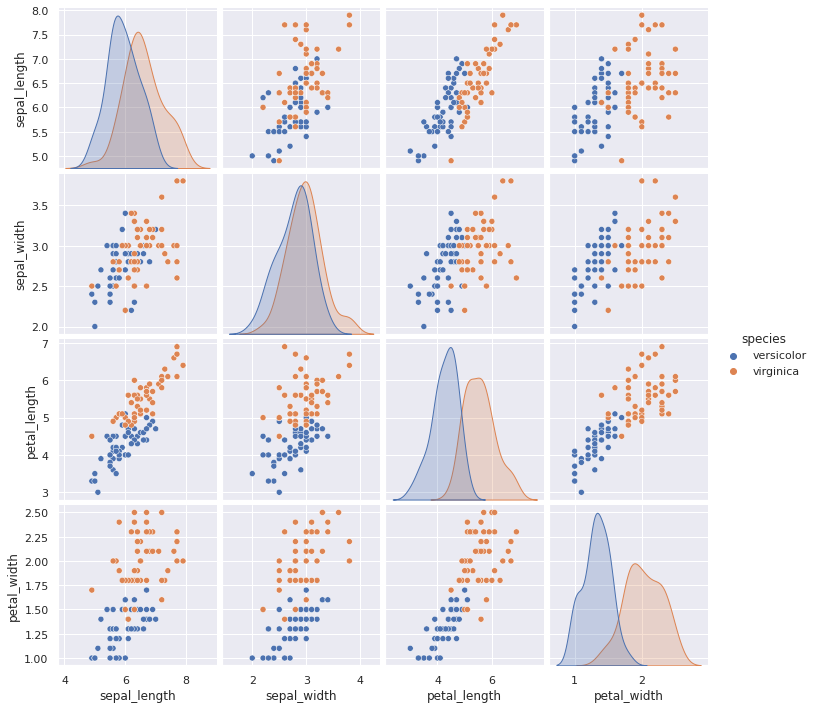

In [4]:
sns.pairplot(iris, hue='species', height=2.5);

For use in Scikit-Learn, we will extract the features matrix and target array from the seaborn dataframe and store them in numpy arrays

In [5]:
X_data = iris.drop('species', axis=1)
X_data = X_data.to_numpy()
X_data.shape


(100, 4)

In [6]:
# create a numeric arrays for the 3 species
y_data = iris.species.replace({'setosa': 2, 'versicolor': 1, 'virginica': 0}, inplace=False)
y_data = y_data.to_numpy()
y_data.shape


(100,)

In [7]:
## uncommend it if you want to try other data
# from sklearn.datasets import make_circles
# X_data, y_data = make_circles(100, factor=.8, noise=.3)

---
## Task 1: Linear SVM [8 points]

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.

We covered the theory behind the algorithm in the class (see videos and slides on Canvas). For the pracrical implementation please refer to the nice tutorial on: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb

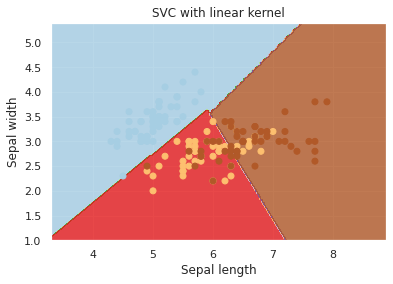

NameError: ignored

In [11]:
### Task 4: your code goes here
# import svm datasets

# Import the Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
  
# Import some Data from the iris Data Set
iris = datasets.load_iris()
  
# Take only the first two features of Data.
# To avoid the slicing, Two-Dim Dataset can be used
  
X = iris.data[:, :2]
y = iris.target
  
# C is the SVM regularization parameter
C = 1.0 
  
# Create an Instance of SVM and Fit out the data.
# Data is not scaled so as to be able to plot the support vectors
svc = svm.SVC(kernel ='linear', C = 1).fit(X, y)
  
# create a mesh to plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
         np.arange(y_min, y_max, h))
  
# Plot the data for Proper Visual Representation
plt.subplot(1, 1, 1)
  
# Predict the result by giving Data to the model
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap = plt.cm.Paired, alpha = 0.8)
  
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.title('SVC with linear kernel')
  
# Output the Plot
plt.show()

# 
# 
# replace the line below with the prediction of your model
y_pred = y_test

In [ ]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_linear);
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

### Document Task 4 [2 points]
Below describe your solution and how you have done it in 2-3 sentences. Interpret the results. 

---
## Task 2: Kernel SVM [8 points]

Where SVM becomes extremely powerful is when it is combined with *kernels*.
Kernels can also be used as the basis function regressions of [In Depth: Linear Regression](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb).
Also there the data can be projected into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby can be fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. In this task, use nonlinear kernels for the SVC function and experiment with the parameters to become as high accuracy as possible. DO not change the parameter $C$ in this task -- this will be the goal of the next task. 


In [ ]:
### Task 5: your code goes here
# 
# 
# 
# replace the line below with the prediction of your model
y_pred = y_test

In [ ]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_kernel)
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

### Document Task 5 [2 points]
Below describe your solution and how you have done it in 2-3 sentences. Interpret the results. 

---
## Task 3: Tuning the SVM: Softening Margins [8 points]

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?

To handle this case, the SVM implements the **slack-variables** which "soften" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

Experiment with $C$ and the kernel functions from Task 5 in order to get best accuracy on the given dataset. 

In [12]:
### Task 6: your code goes here [5 points]
# 
# 
# 
# replace the line below with the prediction of your model
y_pred = y_test

NameError: ignored

NameError: ignored

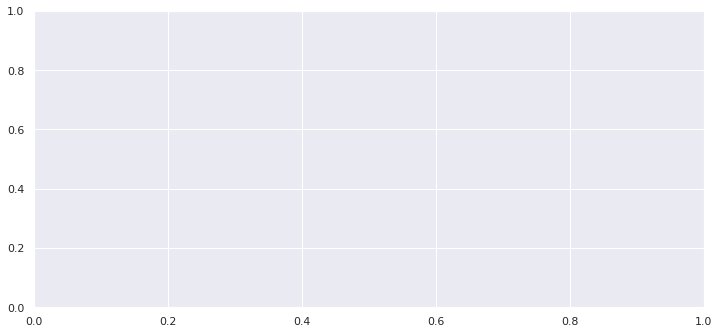

In [13]:
plt.subplots(figsize=(12, 12))
plt.subplot(2,1,1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(svm_soft)
plt.show()

plt.subplot(2,1,2)
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(y_test, y_pred));

### Document Task 6 [2 points]
Below describe your solution and how you have done it in 2-3 sentences. Interpret the results. 